<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/lab_tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3. Siamese Network

The Siamese Neural Network consists of two identical networks joined at their outputs.

The two networks extract feature vectors from two different samples.

Usually, the weights of the two networks are shared, the objective function of the optimization for training the parameters of the networks is defined by using these extracted feature vectors.

The parameters of the Siamese Network are trained to distinguish between similar and dissimilar pairs of the training samples. 

This network architecture is usually used for metric learning, and a contrastive loss over the metric defined on the trained representation is used as the objective function for the optimization. The objective function is defined as

\begin{align}
E&=\frac{1}{2N}\sum_i^N \sum_j^N l_{ij}(D_{ij})^2 + (1-l_{ij})max(m-D_{ij}, ~0)^2 \\
D_{ij}&=||{\boldsymbol y}_{i}-{\boldsymbol y}_{j}||^2_2
\end{align}

where $m$ is a parameter indicating the distance between clusters and $D_{ij}$ represents the distance between the pair of the outputs $\boldsymbol{y}_i$ and $\boldsymbol{y}_j$ of each network for the sample pair $\boldsymbol{x}_i$ and$\boldsymbol{x}_j$.

A label $l$ is assigned for each sample pair such that label is $l_{ij}=1$ when the pair $i$ and $j$ is similar and label is $l_{ij}=0$ when the pair $i$ and $j$ is dissimilar.

After the training of Siamese Network, the outputs for dissimilar pair will be dissimilar while the outputs for similar pair become similar.

※If you want to perform learning, create a source file.

Import of required library.

In [2]:
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import Tensor
import torch.nn.functional as F

Fixed seed value for random numbers.

In [3]:
torch.cuda.manual_seed_all(100100)
torch.manual_seed(100100)
np.random.seed(100100)

Reading dataset.

In [4]:
mnist_train = dsets.MNIST("./data", download=True, train=True)
x_train = []
y_train = []
x_test = []
y_test = []

mnist_test = dsets.MNIST("./data", download=True, train=False)



for i in range(len(mnist_train)):
	x_train.append(np.array(mnist_train[i][0]))
	y_train.append(mnist_train[i][1])
	
for i in range(len(mnist_test)):
	x_test.append(np.array(mnist_test[i][0]))
	y_test.append(mnist_test[i][1])


x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = x_train.reshape(len(mnist_train), 1, 28, 28)
x_train = x_train / 255.0
x_test = np.array(x_test)
y_test = np.array(y_test)
x_test = x_test.reshape(len(mnist_test), 1, 28, 28)
x_test = x_test / 255.0
datasize = len(y_train)
datasize_test = len(y_test)

Designation of mini-batch size and number of epochs.

In [5]:
epoch=100
batchsize=100

Define the model structure.

By alternately inputting two samples to the model and obtaining the respective outputs, the two models sharing weights is designed.

In this example, a two-dimensional feature vector is obtained as output.

In [6]:
class Network(nn.Module):
	def __init__(self):
		super(Network, self).__init__()
		self.conv1 = nn.Conv2d(1,32,3, padding=1)
		self.conv2 = nn.Conv2d(32,32,3, padding=1)
		self.fc1 = nn.Linear(32*7*7, 128)
		self.fc2 = nn.Linear(128, 2)

	def forward(self, x1, x2):
		x1 = F.max_pool2d(F.relu(self.conv1(x1)), 2)
		x1 = F.max_pool2d(F.relu(self.conv2(x1)), 2)
		x1 = x1.view(-1, 32 * 7 * 7)
		x1 = F.relu(self.fc1(x1))
		x1 = self.fc2(x1)

		x2 = F.max_pool2d(F.relu(self.conv1(x2)), 2)
		x2 = F.max_pool2d(F.relu(self.conv2(x2)), 2)
		x2 = x2.view(-1, 32 * 7 * 7)
		x2 = F.relu(self.fc1(x2))
		x2 = self.fc2(x2)
		return x1, x2

	def forward_test(self, x):
		x = F.max_pool2d(F.relu(self.conv1(x)), 2)
		x = F.max_pool2d(F.relu(self.conv2(x)), 2)
		x = x.view(-1, 32 * 7 * 7)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x


net = Network()
net.cuda()

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Define loss and optimizer.

In [8]:
import torch
import torch.nn


class ContrastiveLoss(torch.nn.Module):
	def __init__(self, margin=1.0):
		super(ContrastiveLoss, self).__init__()
		self.margin = margin

	def check_type_forward(self, in_types):
		assert len(in_types) == 3


		x0_type, x1_type, y_type = in_types
		assert x0_type.size() == x1_type.shape
		assert x1_type.size()[0] == y_type.shape[0]
		assert x1_type.size()[0] > 0
		assert x0_type.dim() == 2
		assert x1_type.dim() == 2
		assert y_type.dim() == 1

	def forward(self, x0, x1, y):
		self.check_type_forward((x0, x1, y))

		diff = x0 - x1
		dist = diff.norm(dim=1)
		dist_sq = torch.pow(dist, 2)

		mdist = self.margin - dist
		dist = torch.clamp(mdist, min=0.0)
		loss = y * dist_sq + (1 - y) * torch.pow(dist, 2)
		loss = torch.sum(loss) / 2.0 / x0.size()[0]
		return loss

In [9]:
contrastive_loss = ContrastiveLoss(margin=2.0)

optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)

Input data into the model for each mini-batch and perform parameter update.

The number of similar pairs and similar pairs is adjusted to be the same in the minibatch.

In [10]:
train_loss=[]
train_acc=[]
test_loss=[]
test_acc=[]

n_class=10

result = np.empty((y_train.shape[0], 2))
result_test = np.empty((y_test.shape[0], 2))
halfsize = int(datasize / 2)

for epoch in range(1, epoch+1):
  #Create input pair so that the number of pairs of the same class and the number of pairs of different classes are equal.
	x1_train = np.zeros((datasize, 1, 28, 28)).astype(np.float32)
	x2_train = np.zeros((datasize, 1, 28, 28)).astype(np.float32)
	y1_train = np.zeros((datasize, )).astype(np.int32)
	y2_train = np.zeros((datasize, )).astype(np.int32)
	perm = np.random.permutation(datasize)
 
	for i in range(halfsize):
		x1_train[i] = x_train[perm[i]].copy()
		y1_train[i] = y_train[perm[i]].copy()

		temp = np.where(y_train == y1_train[i])[0]
		size = len(temp)
		num = np.random.randint(0, size)
		while(temp[num] == perm[i]):
			num = np.random.randint(0, size)
		x2_train[i] = x_train[temp[num]].copy()
		y2_train[i] = y_train[temp[num]].copy()

	for i in range(halfsize, datasize):
		x1_train[i] = x_train[perm[i]].copy()
		y1_train[i] = y_train[perm[i]].copy()

		temp = np.where(y_train != y1_train[i])[0]
		size = len(temp)
		num = np.random.randint(0, size)
		x2_train[i] = x_train[temp[num]].copy()
		y2_train[i] = y_train[temp[num]].copy()

  
	print('epoch', epoch)
	perm = np.random.permutation(datasize)
	for i in range(0, datasize, batchsize):
		x1_batch = x1_train[perm[i:i+batchsize]]
		y1_batch = y1_train[perm[i:i+batchsize]]
		x2_batch = x2_train[perm[i:i+batchsize]]
		y2_batch = y2_train[perm[i:i+batchsize]]
		label = np.array(y1_batch == y2_batch, dtype=np.int32)
		x1_batch = torch.from_numpy(x1_batch.copy()).float().cuda()
		x2_batch = torch.from_numpy(x2_batch.copy()).float().cuda()
		label = torch.from_numpy(label).float().cuda()
		optimizer.zero_grad()
		y1, y2 = net(x1_batch, x2_batch)
		loss = contrastive_loss(y1, y2, label)           
		loss.backward()                           
		optimizer.step()


	sum_score = 0
	sum_loss = 0

	for i in range(0, datasize, batchsize):
		x1_batch = x_train[perm[i:i+batchsize]]
		y1_batch = y_train[perm[i:i+batchsize]]
		x2_batch = x_train[perm[i:i+batchsize]][::-1]
		y2_batch = y_train[perm[i:i+batchsize]][::-1]
		label = np.array(y1_batch == y2_batch, dtype=np.int32)
		x1_batch = torch.from_numpy(x1_batch.copy()).float().cuda()
		x2_batch = torch.from_numpy(x2_batch.copy()).float().cuda()
		label = torch.from_numpy(label).float().cuda()
		y1, y2 = net(x1_batch, x2_batch)
		loss = contrastive_loss(y1, y2, label)           
		sum_loss += float(loss.cpu().data.item()) * batchsize
	print("train  mean loss={}".format(sum_loss / datasize))
	train_loss.append(sum_loss / datasize)


	sum_score = 0
	sum_loss = 0
	perm = np.random.permutation(datasize_test)
	for i in range(0, datasize_test, batchsize):
		x1_batch = x_test[perm[i:i+batchsize]]
		y1_batch = y_test[perm[i:i+batchsize]]
		x2_batch = x_test[perm[i:i+batchsize]][::-1]
		y2_batch = y_test[perm[i:i+batchsize]][::-1]
		label = np.array(y1_batch == y2_batch, dtype=np.int32)
		x1_batch = torch.from_numpy(x1_batch.copy()).float().cuda()
		x2_batch = torch.from_numpy(x2_batch.copy()).float().cuda()
		label = torch.from_numpy(label).float().cuda()
		y1, y2 = net(x1_batch, x2_batch)
		loss = contrastive_loss(y1, y2, label)           
		sum_loss += float(loss.cpu().data.item()) * batchsize
	print("test  mean loss={}".format(sum_loss / datasize_test))
	test_loss.append(sum_loss / datasize_test)

epoch 1
train  mean loss=0.2022804470360279
test  mean loss=0.20168176159262657
epoch 2
train  mean loss=0.15312216961756347
test  mean loss=0.15227550186216832
epoch 3
train  mean loss=0.16133932871123155
test  mean loss=0.16308092936873436
epoch 4
train  mean loss=0.12419824470455448
test  mean loss=0.12411677200347185
epoch 5
train  mean loss=0.12239766052613656
test  mean loss=0.12216213569045067
epoch 6
train  mean loss=0.11726464718580246
test  mean loss=0.11824187949299812
epoch 7
train  mean loss=0.09882631402773162
test  mean loss=0.09416894130408764
epoch 8
train  mean loss=0.09711303643571834
test  mean loss=0.09141150075942278
epoch 9
train  mean loss=0.11189121623213093
test  mean loss=0.11034282982349396
epoch 10
train  mean loss=0.09703705141320824
test  mean loss=0.10187412727624177
epoch 11
train  mean loss=0.08564962404159208
test  mean loss=0.08504877220839262
epoch 12
train  mean loss=0.10508328965554635
test  mean loss=0.10523857966065407
epoch 13
train  mean loss=

Plot the feature space obtained by learning.

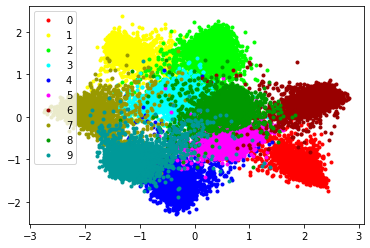

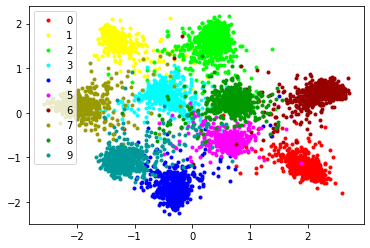

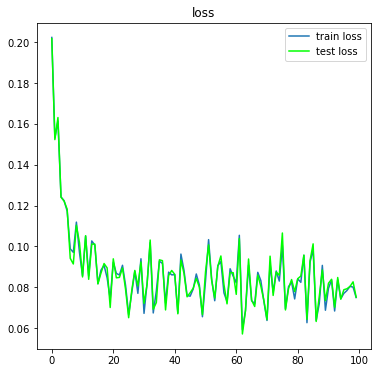

In [11]:
#Get the model output from train data.
for i in range(0, datasize, batchsize):
	x1_batch = x_train[i:i+batchsize]
	x1_batch = torch.from_numpy(x1_batch.copy()).float().cuda()
	test_result = net.forward_test(x1_batch)
	test_result = test_result.cpu().data.numpy()
	result[i:i + batchsize] = test_result


#Get the model output from test data.
for i in range(0, datasize_test, batchsize):
	x1_batch = x_test[i:i+batchsize]
	x1_batch = torch.from_numpy(x1_batch.copy()).float().cuda()
	test_result = net.forward_test(x1_batch)
	test_result = test_result.cpu().data.numpy()
	result_test[i:i + batchsize] = test_result


#plot the obtained output.
c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff','#ff00ff', '#990000', '#999900', '#009900', '#009999']
plt.figure()
for i in range(10):
	feat = result[np.where(y_train == i)]
	plt.plot(feat[:,0], feat[:,1], '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

plt.figure()
for i in range(10):
	feat = result_test[np.where(y_test == i)]
	plt.plot(feat[:,0], feat[:,1], '.', c=c[i])
plt.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
plt.show()

plt.figure(figsize=(6,6))
plt.plot(range(epoch), train_loss)
plt.plot(range(epoch), test_loss, c='#00ff00')
plt.legend(['train loss', 'test loss'])
plt.title('loss')
plt.show()



※Pytorch does not implement contrastive loss, which is a standard loss of the siamese network.

So, if you want to use siamese network with contrastive loss, you need to import the following source code.